# Benchmark model

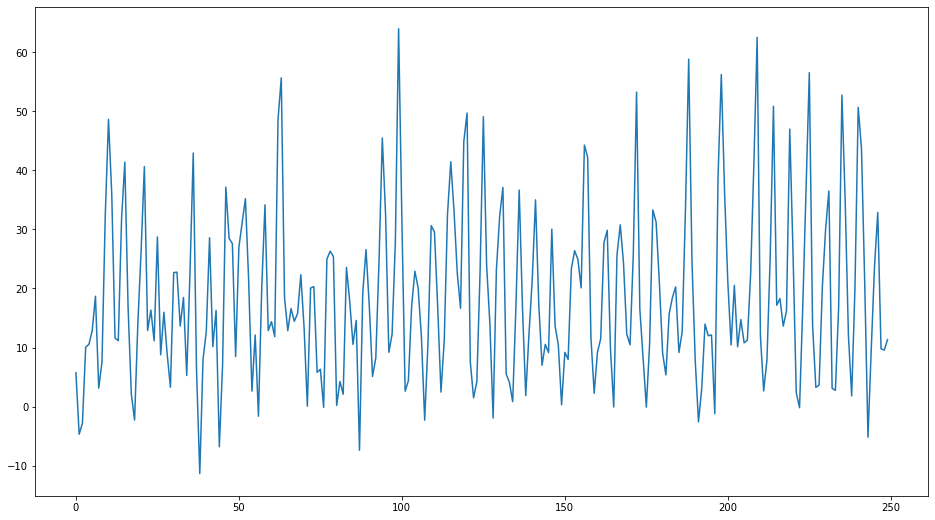

In [7]:
from stochproc import timeseries as ts, distributions as dists
from pyro.distributions import Normal
import torch
import matplotlib.pyplot as plt
from math import sqrt


plt.rcParams["figure.figsize"] = (16, 9)


def mean_scale(x, sigma_x):
    x_t = x.values
    mean = x_t / 2.0 + 10.0 * x_t / (1.0 + x_t) + 8.0 * torch.cos(1.2 * (x.time_index + 1))
    
    return mean, sigma_x


def build_obs(x, sigma_y):
    return Normal(x.values.pow(2.0) / 20.0, sigma_y)


def model(sigma_x, sigma_y):
    init = dists.DistributionModule(Normal, loc=0.0, scale=sqrt(5.0))
    inc = dists.DistributionModule(Normal, loc=0.0, scale=1.0)    
    latent = ts.AffineProcess(mean_scale, (sigma_x,), init, inc)
    
    return ts.StateSpaceModel(latent, build_obs, (sigma_y,))


x, y = model(4, 5).sample_states(250).get_paths()

plt.plot(y)

In [8]:
import pyro
from pyro.distributions import LogNormal
from pyfilter.filters import particle
from pyro.infer import autoguide, SVI
from pyro.optim import Adam
from tqdm import tqdm


def pyro_model(yt, only_params=False):
    sigma_x = pyro.sample("sigma_x", LogNormal(loc=1.0, scale=1.0))
    sigma_y = pyro.sample("sigma_y", LogNormal(loc=1.0, scale=1.0))
    
    ssm = model(sigma_x, sigma_y)
    
    if not only_params:
        filt = particle.APF(ssm, 250, record_states=True)
        filt.do_sample_pyro(yt, pyro)
    
    
guide = autoguide.AutoDiagonalNormal(pyro_model)
optim = Adam({"lr": 0.01})
svi = SVI(pyro_model, guide, optim, loss=pyro.infer.Trace_ELBO())

pyro.clear_param_store()

niter = 1_000
bar = tqdm(range(niter))

alpha = 0.98
running_avg = 0.0

for n in bar:
    loss = svi.step(y)
    
    running_avg = alpha * running_avg + (1 - alpha) * loss
    bar.set_postfix({"loss": f"{loss:.2f}"})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:12<00:00,  1.37it/s, loss=1727.77]


In [9]:
posterior_predictive = pyro.infer.Predictive(
    pyro_model,
    guide=guide,
    num_samples=1_000
)

samples = posterior_predictive(y, only_params=True)

array([<AxesSubplot:title={'center':'sigma_x'}>,
       <AxesSubplot:title={'center':'sigma_y'}>], dtype=object)

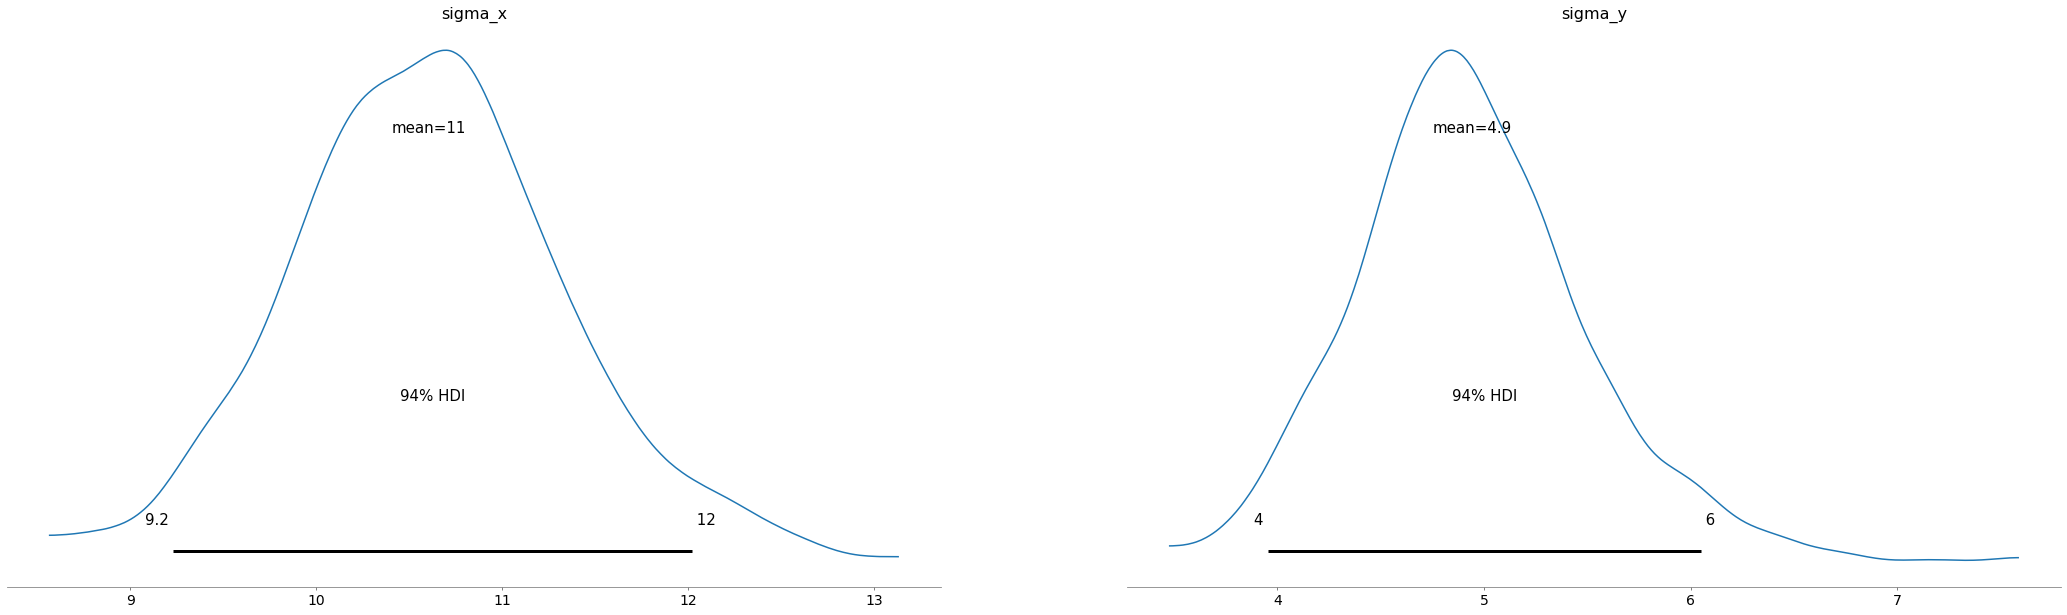

In [10]:
import arviz

posterior_draws = {k: v.unsqueeze(0) for k, v in samples.items()}

posteriors = arviz.from_dict(posterior_draws)
arviz.plot_posterior(posteriors, var_names=["sigma_x", "sigma_y"])